# "Building an interactive data browser"
> "Lightweight, performant exploration of chemical space"

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/b-akshay/blog-tools/blob/master/interactive-browser/scatter_chemviz.ipynb)

# The rudiments of a computational browser

In exploring [chemical space](https://en.wikipedia.org/wiki/Chemical_space) in various ways for drug discovery, I often find it useful to be able to: 

1. *See* many molecules at once, viewing their structures interactively
1. *Select* and group subsets of chemicals based on their properties, and *save* them for future use
1. Do this in a **modular** manner that can be **modified** easily as the work changes

This is particularly true in the drug discovery pipeline when doing [hit-to-lead optimization](https://en.wikipedia.org/wiki/Hit_to_lead) or later. 
So there's a rich ecosystem of software solutions to these issues -- many of us working in drug discovery have sat through demos of this functionality wrapped in a software package. 
Such solutions can be difficult to develop upon, because they tend to be:
- Specialized: addressing only some of the above points
- Commoditized: not free-to-use and modular, with proprietary analyses

These are ground realities that arise for various reasons that are increasingly [debated](https://twitter.com/dr_alphalyrae/status/1525887314488008704). 
Nevertheless, in many situations, it's more convenient to write one's own [tools](https://practicalcheminformatics.blogspot.com/2019/11/interactive-plots-with-chemical.html) to enable easier exploration. 
Even outside of cheminformatics uses, I've found other occasions to use such interactive functionality, when exploring other [spaces](https://coessentiality.net/), and have learned a few things about designing basic interactive tools. 

Inspired by all this, I'm going to show how to build a simple but highly functional pipeline for iterative exploration of any dataset, as a mock-up in a [virtual screening](https://en.wikipedia.org/wiki/Virtual_screening) workflow. 
Without much code, we can set up this type of data-centered interface in a performant and customizable way. 

For the result of this pipeline without all the explanation, please see the associated [code](https://github.com/b-akshay/blog-tools) and [deployment](https://akshay.bio/blog/interactive-browser/#Launching-this-as-an-app) instructions.

## Notes on an interactive framework

Most scientific programming is done in [imperative](https://en.wikipedia.org/wiki/Imperative_programming) settings, in which the control flow of the program is explicitly specified. 
A major difference here in building an inherently interactive framework is that it's necessary to choose a [declarative](https://en.wikipedia.org/wiki/Declarative_programming)/[reactive](https://en.wikipedia.org/wiki/Reactive_programming) programming paradigm, in which we define *callbacks* that automatically propagate changes in any user-selected variable to runtime environment variables. 
So the programmer maintains a state that the app can rely upon for its behavior, minimizing *concurrency* issues where the system's state is in question.
This paradigm dominates [web programming](https://en.wikipedia.org/wiki/React_(JavaScript_library)).

We also want to design data-driven apps with good cheminformatics and bioinformatics support capabilities, for which the Python language has probably the largest ecosystem. 
With all these considerations in mind, I'll use the widely-used and expressive [Dash and Plotly](https://plotly.com/dash/) interactive frameworks to demonstrate how to build such an app to assist in unsupervised browsing of data.

The workflow will be structured in two parts:

- **Preprocessing script**: Given a dataset of chemicals, writes a dataframe that's ready to be viewed by a front-end. 
- **Interactive application**: Given a dataframe, view it interactively in a browser.


# Preprocessing script

Here I'll assemble and write a dataframe that's ready to render by an interactive front-end. 
The data aren't really my focus here, so I'll fetch and preprocess a collection of molecules for the purposes of this post.


## Fetching data

Here, I'll download [all small-molecule FDA-approved drugs](https://zinc20.docking.org/substances/subsets/fda.txt:zinc_id+smiles+preferred_name+mwt+logp+rb?count=all) from the [ZINC](https://zinc20.docking.org/) database of commercially available chemicals. 
We also download [all drugs approved outside America](https://zinc20.docking.org/substances/subsets/world-not-fda.txt:zinc_id+smiles+preferred_name+mwt+logp+rb?count=all), 
and combine them to see where the listed FDA-approved drugs lie in chemical space. 

This dataset constitutes ~5,000 chemicals. 
In this workflow, only the 2D chemical structure (SMILES string) is needed for each molecule. 
In practice, we might use an even larger superset of these chemicals in ZINC. 

In [ ]:
#hide
#!pip install anndata scanpy
#!pip install rdkit-pypi scikit-learn gdown
#!pip install dash deepchem

In [65]:
#collapse-hide

import pandas as pd, time

fda_fname = 'fda_zinc20.txt'
fda_url = 'https://zinc20.docking.org/substances/subsets/fda.txt:zinc_id+smiles+preferred_name+mwt+logp+rb?count=all'
fda_molecules = pd.read_csv(fda_url, header=None, index_col=0, sep='\t')
fda_molecules['dataset'] = 'FDA'

worldnotfda_fname = 'world-not-fda_zinc20.txt'
worldnotfda_url = 'https://zinc20.docking.org/substances/subsets/world-not-fda.txt:zinc_id+smiles+preferred_name+mwt+logp+rb?count=all'
worldnotfda_molecules = pd.read_csv(worldnotfda_url, header=None, index_col=0, sep='\t')
worldnotfda_molecules['dataset'] = 'world-not-FDA'

all_chems = pd.concat([fda_molecules, worldnotfda_molecules])
all_chems.columns = ['SMILES', 'Preferred name', 'Molecular weight', 'Log P', 'Rotatable bonds', 'dataset']

## Featurizing the data

I'll first featurize the chemical structures by calculating molecular fingerprints, using the wonderful open [DeepChem](https://deepchem.readthedocs.io/en/latest/) library. 

The standard way of doing this, extended-connectivity Morgan fingerprints, has turned out to provide good performance in practice, as well as simplicity and flexibility. It basically constructs nonredundant radially structured atom-centered features; here is a good [explanation](https://depth-first.com/articles/2019/01/11/extended-connectivity-fingerprints/) based on the original [paper](https://pubs.acs.org/doi/10.1021/ci100050t).

<!-- https://chemicbook.com/2021/03/25/a-beginners-guide-for-understanding-extended-connectivity-fingerprints.html -->

In [ ]:
#collapse-hide

import deepchem as dc

itime = time.time()
featurizer = dc.feat.CircularFingerprint()
feature_mat = featurizer.featurize(list(all_chems['SMILES']))
print("Data featurized. Time: {}".format(time.time() - itime))

## Calculating some metadata

To demonstrate the browsability of this data, we can calculate some chemical descriptors for each molecule using the popular cheminformatics [RDKit](https://deepchem.readthedocs.io/en/latest/) package.

In [ ]:
#collapse-hide

# Calculating some chemical descriptors using RDKit.

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors, Descriptors3D, Draw, rdMolDescriptors, Draw, PandasTools
from rdkit.Chem.Draw import IPythonConsole

featurizer = dc.feat.RDKitDescriptors()
features = featurizer.featurize(list(all_chems['SMILES']))
metadata_df = pd.DataFrame(data=features, index=all_chems.index, columns=featurizer.descriptors)

metadata_df = metadata_df.join(all_chems)
metadata_df.index.name = 'ZINC_ID'

## Embedding and writing the data

After embedding the featurized data, I'll serialize everything using the [anndata](https://github.com/scverse/anndata) and [scanpy](https://github.com/scverse/scanpy) packages. 
These are two packages designed for the growing world of [single-cell](https://en.wikipedia.org/wiki/Single_cell_sequencing) data analysis, but I definitely advocate using them for more general data. 
In my opinion, they make it very easy to perform nonparametric data analysis and plot an embedding space. 

Here, we'll use these packages to process the data, computing a neighborhood graph and relying on the `anndata` package to write a `.h5` file with the data in a form that's ready to visualize. 
The idea of `anndata` is to use this `.h5` file to store annotations for a data matrix ((# observations) $\times$ (# variables)). 


<figure style="width:80%" class="center">
    <div style="display:flex">
        <div style="flex:1">
            <figure>
<img src="https://anndata.readthedocs.io/en/latest/_images/anndata_schema.svg">
                <figcaption><center>Anndata schema<br>(https://anndata.readthedocs.io/en/latest/_images/anndata_schema.svg)</center></figcaption>
            </figure>
        </div>
    </div>
</figure>

<!-- ![](https://raw.githubusercontent.com/scverse/anndata/a3af650d40fd804cd866d55a674a7eeaa20fdec0/docs/_static/img/anndata_schema.svg "Credit: https://raw.githubusercontent.com/scverse/anndata/a3af650d40fd804cd866d55a674a7eeaa20fdec0/docs/_static/img/anndata_schema.svg")-->


This paradigm is very useful for data analyses, but for now I won't explore it in detail, just using it to store the chemical fingerprints (feature vectors, for any machine learning method) alongside the chemical descriptors (metadata). 
So the central data matrix `X` will contain each chemical's fingerprint as a row, and the parallel dataframe `.obs` contains the descriptors.{% fn 1 %} 

{{ "These two files can easily be serialized separately, as an array and a dataframe." | fndetail: 1 }}

In [ ]:
#collapse-hide
#hide-output

import scanpy as sc, anndata

anndata_all = anndata.AnnData(X=feature_mat, obs=metadata_df)

itime = time.time()
# Do PCA for denoising and dimensionality reduction
sc.pp.pca(anndata_all, n_comps=10)
print("PCA computed. Time: {}".format(time.time() - itime))

# Compute neighborhood graph in PCA space
sc.pp.neighbors(anndata_all)
print("Neighbors computed. Time: {}".format(time.time() - itime))

# Compute UMAP using neighborhood graph
sc.tl.umap(anndata_all)
print("UMAP calculated. Time: {}".format(time.time() - itime))

sc.pl.umap(anndata_all, color='Molecular weight') #, s=4)

anndata_all.obs['x'] = anndata_all.obsm['X_umap'][:, 0]
anndata_all.obs['y'] = anndata_all.obsm['X_umap'][:, 1]
anndata_all.write('approved_drugs.h5')
print("Data written. Time: {}".format(time.time() - itime))

The front-end we'll build next will rely on two things being stored:
- The data matrix, consisting of a feature vector (in this case, a chemical fingerprint) for each observation
- Metadata (in this case, chemical descriptors) for each observation

# Setting up an interactive browser

Now let's move on to the interactive front-end that will display the dataset.

## Styles and colors

I like to initialize some boilerplate colormap and display code to make things look a bit nicer than the defaults.

In [2]:
#collapse-hide

import seaborn as sns

# Custom colorscales.
# From https://github.com/BIDS/colormap/blob/master/parula.py
# pc = [matplotlib.colors.to_hex(x) for x in parulac]; d = np.arange(len(pc)); d = np.round(d/max(d), 4); parula = [x for x in zip(d, pc)]
cmap_parula = [(0.0, '#352a87'), (0.0159, '#363093'), (0.0317, '#3637a0'), (0.0476, '#353dad'), (0.0635, '#3243ba'), (0.0794, '#2c4ac7'), (0.0952, '#2053d4'), (0.1111, '#0f5cdd'), (0.127, '#0363e1'), (0.1429, '#0268e1'), (0.1587, '#046de0'), (0.1746, '#0871de'), (0.1905, '#0d75dc'), (0.2063, '#1079da'), (0.2222, '#127dd8'), (0.2381, '#1481d6'), (0.254, '#1485d4'), (0.2698, '#1389d3'), (0.2857, '#108ed2'), (0.3016, '#0c93d2'), (0.3175, '#0998d1'), (0.3333, '#079ccf'), (0.3492, '#06a0cd'), (0.3651, '#06a4ca'), (0.381, '#06a7c6'), (0.3968, '#07a9c2'), (0.4127, '#0aacbe'), (0.4286, '#0faeb9'), (0.4444, '#15b1b4'), (0.4603, '#1db3af'), (0.4762, '#25b5a9'), (0.4921, '#2eb7a4'), (0.5079, '#38b99e'), (0.5238, '#42bb98'), (0.5397, '#4dbc92'), (0.5556, '#59bd8c'), (0.5714, '#65be86'), (0.5873, '#71bf80'), (0.6032, '#7cbf7b'), (0.619, '#87bf77'), (0.6349, '#92bf73'), (0.6508, '#9cbf6f'), (0.6667, '#a5be6b'), (0.6825, '#aebe67'), (0.6984, '#b7bd64'), (0.7143, '#c0bc60'), (0.7302, '#c8bc5d'), (0.746, '#d1bb59'), (0.7619, '#d9ba56'), (0.7778, '#e1b952'), (0.7937, '#e9b94e'), (0.8095, '#f1b94a'), (0.8254, '#f8bb44'), (0.8413, '#fdbe3d'), (0.8571, '#ffc337'), (0.873, '#fec832'), (0.8889, '#fcce2e'), (0.9048, '#fad32a'), (0.9206, '#f7d826'), (0.9365, '#f5de21'), (0.9524, '#f5e41d'), (0.9683, '#f5eb18'), (0.9841, '#f6f313'), (1.0, '#f9fb0e')]

# Default discrete colormap for <= 20 categories, from https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/. See also http://phrogz.net/css/distinct-colors.html and http://tools.medialab.sciences-po.fr/iwanthue/
cmap_custom_discrete = ["#bdbdbd", '#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#7d87b9', '#bec1d4', '#d6bcc0']

# Convenient discrete colormaps for large numbers of colors.
cmap_custom_discrete_44 = ['#745745', '#568F34', '#324C20', '#FF891C', '#C9A997', '#C62026', '#F78F82', '#EF4C1F', '#FACB12', '#C19F70', '#824D18', '#CB7513', '#FBBE92', '#CEA636', '#F9DECF', '#9B645F', '#502888', '#F7F79E', '#007F76', '#00A99D', '#3EE5E1', '#65C8D0', '#3E84AA', '#8CB4CD', '#005579', '#C9EBFB', '#000000', '#959595', '#B51D8D', '#C593BF', '#6853A0', '#E8529A', '#F397C0', '#DECCE3', '#E18256', '#9BAA67', '#8ac28e', '#68926b', '#647A4F', '#CFE289', '#00C609', '#C64B55', '#953840', '#D5D5D5']
cmap_custom_discrete_74 = ['#FFFF00', '#1CE6FF', '#FF34FF', '#FF4A46', '#008941', '#006FA6', '#A30059', '#FFDBE5', '#7A4900', '#0000A6', '#63FFAC', '#B79762', '#004D43', '#8FB0FF', '#997D87', '#5A0007', '#809693', '#6A3A4C', '#1B4400', '#4FC601', '#3B5DFF', '#4A3B53', '#FF2F80', '#61615A', '#BA0900', '#6B7900', '#00C2A0', '#FFAA92', '#FF90C9', '#B903AA', '#D16100', '#DDEFFF', '#000035', '#7B4F4B', '#A1C299', '#300018', '#0AA6D8', '#013349', '#00846F', '#372101', '#FFB500', '#C2FFED', '#A079BF', '#CC0744', '#C0B9B2', '#C2FF99', '#001E09', '#00489C', '#6F0062', '#0CBD66', '#EEC3FF', '#456D75', '#B77B68', '#7A87A1', '#788D66', '#885578', '#FAD09F', '#FF8A9A', '#D157A0', '#BEC459', '#456648', '#0086ED', '#886F4C', '#34362D', '#B4A8BD', '#00A6AA', '#452C2C', '#636375', '#A3C8C9', '#FF913F', '#938A81', '#575329', '#00FECF', '#B05B6F']

# Custom red/blue diverging for black background, from https://gka.github.io/palettes
cmap_custom_rdbu_diverging = [[0.0, '#0000ff'], [0.1111, '#442dfa'], [0.2222, '#6b59e0'], [0.3333, '#6766a3'], [0.4444, '#323841'], [0.5555, '#483434'], [0.6666, '#b3635b'], [0.7777, '#ee5d49'], [0.8888, '#ff3621'], [1.0, '#ff0000']]

# Custom yellow/blue diverging for black background. From the following code:
# x = sns.diverging_palette(227, 86, s=98, l=77, n=20, center='dark').as_hex(); [s for s in zip(np.arange(len(x))/(len(x)-1), x)]
cmap_custom_ylbu_diverging = [(0.0, '#3acdfe'), (0.0526, '#37bbe6'), (0.105, '#35a9cf'), (0.157, '#3295b6'), (0.210, '#2f829e'), (0.263, '#2d6f85'), (0.315, '#2a5d6e'), 
                              (0.368, '#274954'), (0.421, '#25373d'), (0.473, '#222324'), (0.526, '#232322'), (0.578, '#363621'), (0.631, '#474720'), (0.684, '#5a5a1e'), 
                              (0.736, '#6b6b1d'), (0.789, '#7e7e1c'), (0.842, '#8f901b'), (0.894, '#a2a21a'), (0.947, '#b3b318'), (1.0, '#c4c417')]
cmap_custom_orpu_diverging = [(0.0, '#c2b5fe'), (0.0526, '#b1a5e6'), (0.105, '#a096cf'), (0.157, '#8e85b6'), (0.210, '#7c759e'), (0.263, '#6a6485'), (0.315, '#59556e'), 
                              (0.368, '#464354'), (0.421, '#35343d'), (0.473, '#232324'), (0.526, '#242323'), (0.578, '#3d332a'), (0.631, '#544132'), (0.684, '#6e523a'), 
                              (0.736, '#856041'), (0.789, '#9e7049'), (0.842, '#b67f50'), (0.894, '#cf8f58'), (0.947, '#e79d5f'), (1.0, '#feac66')]

"""
Interprets dataset to get list of colors, ordered by corresponding color values.
"""
def get_discrete_cmap(num_colors_needed):
    cmap_discrete = cmap_custom_discrete_44
    # If the provided color map has insufficiently many colors, make it cycle
    if len(cmap_discrete) < num_colors_needed:
        cmap_discrete = sns.color_palette(cmap_discrete, num_colors_needed)
        cmap_discrete = ['#%02x%02x%02x' % (int(255*red), int(255*green), int(255*blue)) for (red, green, blue) in cmap_discrete]
    return cmap_discrete


params = {}

params['title'] = "Chemical space viewer"

# Can reverse black/white color scheme
bg_scheme_list = ['black', 'white']
params['bg_color'] = 'white'
params['legend_bgcolor'] = 'white'
params['edge_color'] = 'white'
params['font_color'] = 'black'
params['legend_bordercolor'] = 'black'
params['legend_font_color'] = 'black'

params['hm_colorvar_name'] = 'Value'
params['qnorm_plot'] = False
params['hm_qnorm_plot'] = False

params['colorscale_continuous'] = [(0, "blue"), (0.5, "white"), (1, "red")]    # 'Viridis'
params['colorscale'] = cmap_custom_discrete_44

params['hover_edges'] = ""
params['edge_width'] = 1
params['bg_marker_size_factor'] = 5
params['marker_size_factor'] = 5
params['bg_marker_opacity_factor'] = 0.5
params['marker_opacity_factor'] = 1.0
params['legend_font_size'] = 16
params['hm_font_size'] = 6

legend_font_macro = { 'family': 'sans-serif', 'size': params['legend_font_size'], 'color': params['legend_font_color'] }
colorbar_font_macro = { 'family': 'sans-serif', 'size': 8, 'color': params['legend_font_color'] }
hm_font_macro = { 'family': 'sans-serif', 'size': 8, 'color': params['legend_font_color'] }

style_unselected = { 'marker': { 'size': 2.5, 'opacity': 1.0 } }
style_selected = { 'marker': { 'size': 6.0, 'opacity': 1.0 } }
style_outer_dialog_box = { 'padding': 10, 'margin': 5, 'border': 'thin lightgrey solid', # 'borderRadius': 5, 
}

style_invis_dialog_box = { 'padding': 0, 'margin': 5 }
style_hm_colorbar = { 
    'len': 0.3, 'thickness': 20, 'xanchor': 'left', 'yanchor': 'top', 'title': params['hm_colorvar_name'], 'titleside': 'top', 'ticks': 'outside', 
    'titlefont': legend_font_macro, 'tickfont': legend_font_macro 
}
style_text_box = { 'textAlign': 'center', 'width': '100%', 'color': params['font_color'] }

style_legend = {
    'font': legend_font_macro, # bgcolor=params['legend_bgcolor'], 'borderwidth': params['legend_borderwidth'], 
    'borderwidth': 0, #'border': 'thin lightgrey solid', 
    'traceorder': 'normal', 'orientation': 'h', 
    'itemsizing': 'constant'
}

## Displaying chemical space as a scatterplot

Next, here's a utility function that wraps around the Plotly scatterplot rendering utility, using and exposing a lot of its underlying parameters. 
This is useful boilerplate because it abstracts away often-irrelevant implementation details. 

<details>
<summary>${\normalsize \textbf{Details}}$</summary>
<div class="tip" markdown="1">
- The code in `run_update_scatterplot()` attempts to automatically detect whether a discrete or continuous colormap is needed; it uses a discrete colormap unless more than 50 distinct values would be needed, in which case a continuous one is used.
- The code uses several display configuration options from the `params` dictionary defined above. The code could be fewer lines, but everyone likes different display configurations!
- The main implementation details here arise from the differences in handling discrete and continuous colorscales, which affects subset selection and annotation of points.
- Further details, like the displayed name of the color variable, are set to generic defaults that are exposed in the code and can be changed.
</div>
</details>

In [3]:
#collapse-hide

import numpy as np

"""
Returns scatterplot panel with selected points annotated, using the given dataset (in data_df) and color scheme.
"""
def build_main_scatter(
    data_df, color_var, 
    discrete=False, 
    bg_marker_size=params['bg_marker_size_factor'], marker_size=params['marker_size_factor'], 
    annotated_points=[], selected_point_ids=[], 
    highlight=False, selected_style=style_selected
):
    # Put arrows to annotate points if necessary
    annots = []
    point_names = np.array(data_df.index)
    looked_up_ndces = np.where(np.in1d(point_names, annotated_points))[0]
    for point_ndx in looked_up_ndces:
        absc = absc_arr[point_ndx]
        ordi = ordi_arr[point_ndx]
        cname = point_names[point_ndx]
        annots.append({
            'x': absc, 'y': ordi,
            'xref': 'x', 'yref': 'y', 
            # 'text': '<b>Cell {}</b>'.format(cname), 
            'font': { 'color': 'white', 'size': 15 }, 
            'arrowcolor': '#ff69b4', 'showarrow': True, 'arrowhead': 2, 'arrowwidth': 2, 'arrowsize': 2, 
            'ax': 0, 'ay': -50 
        })
    if highlight:
        selected_style['marker']['color'] = '#ff4f00' # Golden gate bridge red
        selected_style['marker']['size'] = 10
    else:
        selected_style['marker'].pop('color', None)    # Remove color if exists
        selected_style['marker']['size'] = 10
    
    traces_list = []
    cumu_color_dict = {}
    
    # Check to see if color_var is continuous or discrete and plot points accordingly
    if not discrete:     # Color_var is continuous
        continuous_color_var = np.array(data_df[color_var])
        spoints = np.where(np.isin(point_names, selected_point_ids))[0]
        # print(time.time() - itime, spoints, selected_point_ids)
        colorbar_title = params['hm_colorvar_name']
        pt_text = ["{}<br>Value: {}".format(point_names[i], round(continuous_color_var[i], 3)) for i in range(len(point_names))]
        max_magnitude = np.percentile(np.abs(continuous_color_var), 98)
        min_magnitude = np.percentile(np.abs(continuous_color_var), 2)
        traces_list.append({ 
            'name': 'Data', 
            'x': data_df['x'], 
            'y': data_df['y'], 
            'selectedpoints': spoints, 
            'hoverinfo': 'text', 
            'hovertext': pt_text, 
            'text': point_names, 
            'mode': 'markers', 
            'marker': {
                'size': bg_marker_size, 
                'opacity': params['marker_opacity_factor'], 
                'symbol': 'circle', 
                'showscale': True, 
                'colorbar': {
                    'len': 0.3, 
                    'thickness': 20, 
                    'xanchor': 'right', 'yanchor': 'top', 
                    'title': colorbar_title,
                    'titleside': 'top',
                    'ticks': 'outside', 
                    'titlefont': colorbar_font_macro, 
                    'tickfont': colorbar_font_macro
                }, 
                'color': continuous_color_var, 
                'colorscale': 'Viridis', #cmap_parula, #[(0, "white"), (1, "blue")], 
                'cmin': min_magnitude, 
                'cmax': max_magnitude
            }, 
            'selected': selected_style, 
            'type': 'scattergl'
        })
    else:    # Categorical color scheme, one trace per color
        cnt = 0
        num_colors_needed = len(np.unique(data_df[color_var]))
        colorscale_list = get_discrete_cmap(num_colors_needed)
        for idx in np.unique(data_df[color_var]):
            val = data_df.loc[data_df[color_var] == idx, :]
            point_ids_this_trace = list(val.index)
            spoint_ndces_this_trace = np.where(np.isin(point_ids_this_trace, selected_point_ids))[0]
            if idx not in cumu_color_dict:
                trace_color = colorscale_list[cnt]
                cnt += 1
                cumu_color_dict[idx] = trace_color
            trace_opacity = 1.0
            pt_text = ["{}<br>{}".format(point_ids_this_trace[i], idx) for i in range(len(point_ids_this_trace))]
            trace_info = {
                'name': str(idx), 
                'x': val['x'], 
                'y': val['y'], 
                'selectedpoints': spoint_ndces_this_trace, 
                'hoverinfo': 'text', 
                'hovertext': pt_text, 
                'text': point_ids_this_trace, 
                'mode': 'markers', 
                'opacity': trace_opacity, 
                'marker': { 'size': bg_marker_size, 'opacity': params['marker_opacity_factor'], 'symbol': 'circle', 'color': trace_color }, 
                'selected': selected_style
            }
            trace_info.update({'type': 'scattergl'})
            if False: #params['three_dims']:
                trace_info.update({ 'type': 'scatter3d', 'z': np.zeros(val.shape[0]) })
            traces_list.append(trace_info)
    
    return { 
        'data': traces_list, 
        'layout': {
            'margin': { 'l': 0, 'r': 0, 'b': 0, 't': 20}, 
            'clickmode': 'event',  # https://github.com/plotly/plotly.js/pull/2944/
            'hovermode': 'closest', 
            'dragmode': 'select', 
            'uirevision': 'Default dataset',     # https://github.com/plotly/plotly.js/pull/3236
            'xaxis': {
                'automargin': True, 
                'showticklabels': False, 
                'showgrid': False, 'showline': False, 'zeroline': False, 'visible': False 
                #'style': {'display': 'none'}
            }, 
            'yaxis': {
                'automargin': True, 
                'showticklabels': False, 
                'showgrid': False, 'showline': False, 'zeroline': False, 'visible': False 
                #'style': {'display': 'none'}
            }, 
            'legend': style_legend, 
            'annotations': annots, 
            'plot_bgcolor': params['bg_color'], 
            'paper_bgcolor': params['bg_color']
        }
    }


def run_update_scatterplot(
    data_df, color_var, 
    annotated_points=[],      # Selected points annotated
    selected_style=style_selected, highlighted_points=[]
):
    pointIDs_to_select = highlighted_points
    num_colors_needed = len(np.unique(data_df[color_var]))
    # Anything less than 75 categories is currently considered a categorical colormap.
    discrete_color = (num_colors_needed <= 75)
    return build_main_scatter(
        data_df, color_var, discrete=discrete_color, 
        highlight=True, 
        bg_marker_size=params['bg_marker_size_factor'], marker_size=params['marker_size_factor'], 
        annotated_points=annotated_points, selected_point_ids=pointIDs_to_select, 
        selected_style=selected_style
    )

To demonstrate what this does, here is how to export an interactive HTML scatterplot of a column (the molecular weight `MolWt`) from the dataframe.

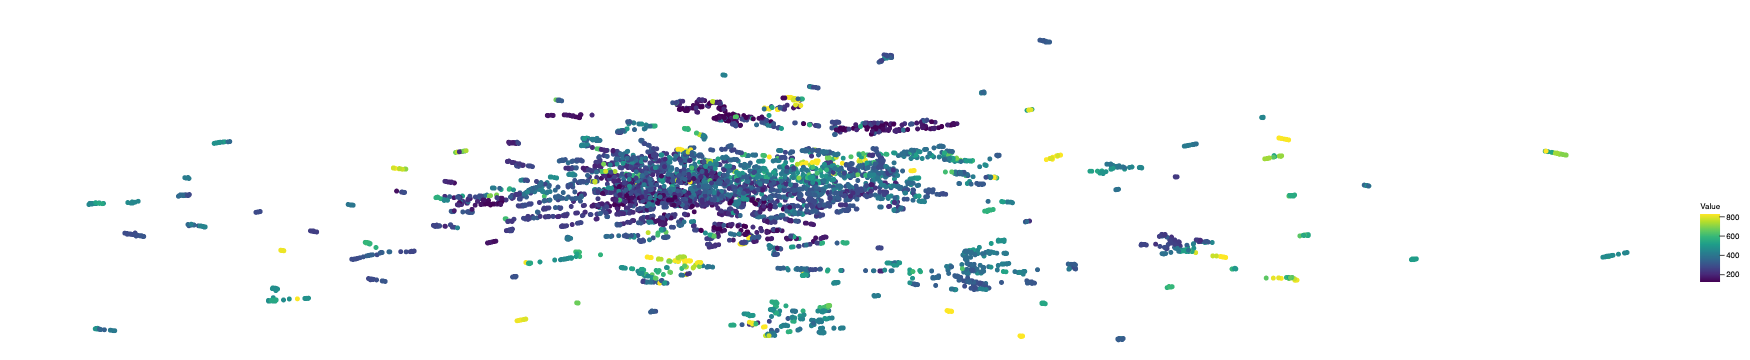

In [7]:
import plotly.graph_objects as go
import scanpy as sc, anndata
import time

anndata_all = sc.read('approved_drugs.h5')
data_df = anndata_all.obs

# Export scatterplot as HTML, and see how long it takes.
itime = time.time()
fig_data = run_update_scatterplot(data_df, 'MolWt')
print("Scatter plot generated. Time: {}".format(time.time() - itime))
fig = go.Figure(**fig_data)

fig.update_layout(showlegend=False)

This is a [Plotly](https://github.com/plotly/plotly.py) interactive figure, so it can be written as a (large) self-contained HTML file if needed, with the following line:

In [ ]:
fig.write_html('scatterplot_test.html')

## Visualizing the scatterplot in an interface

I'll set up an interface with a few major components for now.

- **Color selector** - Adjustable dropdown to select which metadata column is being plotted as the color. Component name: `color-selection`
- **View selected chemicals (text)** - Text box displaying the names of chemicals that are selected. Component name: `selected-chems`
- **View selected chemicals (images)** - Grid of images displaying structures of some of the chemicals that are selected. Component name: `chem2D-image`

The eventual interface assembles these components together like this:

<figure style="width:100%" class="center">
    <div style="display:flex">
        <div style="flex:1">
            <figure>
<img src="post_images/chemspace1.png">
                <figcaption><center></center></figcaption>
            </figure>
        </div>
    </div>
</figure>


Now let's lay out this interface, specifying the components we want. 
Setting up this layout of the interface requires writing some boilerplate HTML-like code in Python, as Dash uses Python dictionaries to flexibly represent markup attributes. 

I'm also introducing a binary flag called `running_colab` in the code, which is set to False by default. Setting it to True modifies the code slightly to run in Google Colab, in which this interactive browser can be deployed if needed.

In [ ]:
running_colab = False

In [24]:
#collapse-hide

import os, base64
from io import BytesIO


import scipy

import dash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output, State
if running_colab:
    from jupyter_dash import JupyterDash


def create_div_mainctrl():
    color_options = list(data_df.columns)
    default_val = color_options[0] if len(color_options) > 0 else ' '
    
    return html.Div(
        children=[
            html.Div(
                className='row', 
                children=[
                    html.Div(
                        className='row', 
                        children=[
                            html.Div(
                                children='Select color: ', 
                                style={ 'textAlign': 'center', 'color': params['font_color'], 'padding-top': '0px' }
                            ), 
                            dcc.Dropdown(
                                id='color-selection', 
                                options = [ {'value': color_options[i], 'label': color_options[i]} for i in range(len(color_options)) ], 
                                value=default_val, 
                                placeholder="Select color...", clearable=False
                            )], 
                        style={'width': '100%', 'padding-top': '10px', 'display': 'inline-block', 'float': 'center'}
                    )
                    ], 
                style={'width': '100%', 'padding-top': '10px', 'display': 'inline-block'}
            ), 
            dcc.Textarea(
                id='selected-chems',
                value=', '.join([]),
                style={'width': '100%', 'height': 100},
            ), 
            html.Div(
                className='six columns', 
                children=[
                    html.A(
                        html.Button(
                            id='download-button', 
                            children='Save', 
                            style=style_text_box, 
                            n_clicks=0, 
                            n_clicks_timestamp=0
                        ), 
                        id='download-set-link',
                        download="selected_set.csv", 
                        href="",
                        target="_blank", 
                        style={
                            'width': '100%', 
                            'textAlign': 'center', 
                            'color': params['font_color']
                        }
                    )], 
                style={'padding-top': '20px'}
            ), 
            html.Div([html.Img(id="chem2D-image")], style={'width': '50%', 'height': 100} )
        ], 
        style={'width': '29%', 'display': 'inline-block', 'fontSize': 12, 'margin': 5}
    )


def create_div_layout():
    return html.Div(
        className="container", 
        children=[
            html.Div(
                className='row', 
                children=[ html.H1(id='title', children=params['title'], style=style_text_box) ]
            ), 
            html.Div(
                className="browser-div", 
                children=[
                    create_div_mainctrl(), 
                    html.Div(
                        className='row', 
                        children=[
                            html.Div(
                                children=[
                                    dcc.Graph(
                                        id='landscape-plot',
                                        config={'displaylogo': False, 'displayModeBar': True}, 
                                        style={ 'height': '100vh'}
                                    )], 
                                style={}
                            )], 
                        style={'width': '69%', 'display': 'inline-block', 'float': 'right', 'fontSize': 12, 'margin': 5}
                    ), 
                    html.Div([ html.Pre(id='test-select-data', style={ 'color': params['font_color'], 'overflowX': 'scroll' } ) ]),     # For testing purposes only!
                    html.Div(
                        className='row', 
                        children=[ 
                            dcc.Markdown(
                                """ """
                            )], 
                        style={ 'textAlign': 'center', 'color': params['font_color'], 'padding-bottom': '10px' }
                    )],
                style={ 'width': '100vw', 'max-width': 'none' }
            )
        ],
        style={ 'backgroundColor': params['bg_color'], 'width': '100vw', 'max-width': 'none' }
    )


if running_colab:
    JupyterDash.infer_jupyter_proxy_config()
    app = JupyterDash(__name__)
else:
    external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
    app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

# Create server variable with Flask server object for use with gunicorn
server = app.server

app.title = params['title']
app.layout = create_div_layout()

# Writing the app's control flow

In order to make the app functional, we need to write *callback* functions to specify the variable dependencies between the panels. 
These declare relationships between variables belonging to the application state, like a text box or the points selected in a plot. 
Each callback defines some changes that occur in its output variables, based on the state of its input variables. 
Callbacks are triggered when any of their input variables change - in this way, the user can trigger changes in the interface and browse the data.


## Selecting and displaying chemical structures

The essential next step is to display the selected chemical structures. 
The core code to accomplish this is demonstrated below on the first few chemical structures from ZINC.


In [54]:
#collapse-hide

from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage


def b64string_image(smiles_list, molecule_name_list, num_molecules=12, return_encoding=False):
    """
    This code displays the first `num_molecules` molecules given in the input lists. 
    Returns a b64encoded image of the grid of molecules.
    """
    mol_list = [Chem.MolFromSmiles(x) for x in smiles_list]
    img = MolsToGridImage(mol_list[:num_molecules], molsPerRow=4, subImgSize=(150,150), legends=molecule_name_list, returnPNG=False)
    buffered = BytesIO()
    img.save(buffered, format="PNG")
    encoded_image = base64.b64encode(buffered.getvalue())
    if return_encoding:
        return encoded_image.decode()
    else:
        return 'data:image/png;base64,{}'.format(encoded_image.decode())


# Example usage.
from IPython import display

src_str = b64string_image(list(anndata_all.obs['SMILES']), list(anndata_all.obs['Preferred name']), return_encoding=True)
display.HTML(f"<div><img src='data:image/png;base64, {src_str}'/></div>")

Fitting this into the existing app requires a bit more code to handle the formatting of the input selections, and handle empty selections. 
Putting all this together, I'll write the callback for the displayed image `chem2D-image`, which triggers an update whenever a selection or click is made in the scatterplot.

In [ ]:
#collapse-hide

"""
Update the selected chemical image
"""
@app.callback(
    Output('chem2D-image', 'src'),
    [Input('landscape-plot', 'selectedData'), 
     Input('landscape-plot', 'clickData')])
def display_selected_data(
    selected_points, 
    clicked_points, 
    num_molecules=12
):
    empty_plot = "data:image/gif;base64,R0lGODlhAQABAAAAACwAAAAAAQABAAA="
    if selected_points:
        if len(selected_points['points']) == 0:
            return empty_plot
        this_df = data_df.loc[np.array([str(p['text']) for p in selected_points['points']])]
        smiles_list = list(this_df['SMILES'])
        molecule_name_list = list(this_df['Preferred name'])
        src_str = b64string_image(smiles_list, molecule_name_list, num_molecules=num_molecules)
    else:
        return empty_plot
    return src_str

Similarly, the names of the selected chemicals can easily be displayed in the text box `selected-chems`.

In [ ]:
#collapse-hide

"""
Update the text box with selected chemicals.
"""
@app.callback(
    Output('selected-chems', 'value'), 
    [Input('landscape-plot', 'selectedData')])
def update_text_selection(selected_points):
    if (selected_points is not None) and ('points' in selected_points):
        selected_IDs = [str(p['text']) for p in selected_points['points']]
    else:
        selected_IDs = []
    return ', '.join(selected_IDs) + '\n\n'

## Adding state to the browser

It's nice to be able to save the selected chemical names, to refer to later. 
I'll export them as a simple text file, which is easy to write to the user's local disk when the "Save" button is clicked. 

In [ ]:
#collapse-hide

def get_pointIDs(selectedData_points):
    toret = []
    if (selectedData_points is not None) and ('points' in selectedData_points):
        for p in selectedData_points['points']:
            pt_txt = p['text'].split('<br>')[0]
            toret.append(pt_txt)
        return toret
    else:
        return []


@app.callback(
    Output('download-set-link', 'href'),
    [Input('landscape-plot', 'selectedData')]
)
def save_selection(landscape_data):
    subset_store = get_pointIDs(landscape_data)
    save_contents = '\n'.join(subset_store)
    return "data:text/csv;charset=utf-8," + save_contents

# Launching this as an app

The result of this is the browser as an application, which can be run using Dash. 

In [26]:
#collapse-hide

"""
Update the main scatterplot panel.
"""
@app.callback(
    Output('landscape-plot', 'figure'), 
    [Input('color-selection', 'value')]
)
def update_landscape(color_var):
    annotated_points = []
    lscape = run_update_scatterplot(
        data_df, 
        color_var
    )
    return lscape

In [ ]:
if __name__ == '__main__':
    if running_colab:
        app.run_server(mode='external', debug=True)
    else:
        app.run_server(host='0.0.0.0', port=5002, debug=True)

## Deployment

Having made the app, we can host this [externally](https://towardsdatascience.com/the-easiest-way-to-deploy-your-dash-app-for-free-f92c575bb69e) if needed. 
There are other ways to deploy it locally and enjoy the same interactive benefits.

- The code from this notebook is available as a [repository](https://github.com/b-akshay/blog-tools); setting it up an environment will deploy the app. 
- This notebook can be run in Colab to deploy it in the cloud, simply setting `running_colab = True` when that variable is introduced earlier in the notebook.

# Summary

I've showed how to build a flexible working browser with the ability to: 
- Browse a set of chemicals with many different metadata annotations
- Select subgroups of chemicals
- Save the state of selected subgroups

## Rules of thumb for this process

I have found some rules of thumb to be useful when designing such browsers. 
One combines concepts from the very famous ["powers of ten"](https://www.nngroup.com/articles/powers-of-10-time-scales-in-ux/) concept in user interface design. 

<!--{% include info.html text="Computations should all occur within ~0.5 seconds, or be done offline." %} -->
> **Rule of thumb:** Computations should all occur within ~0.5 seconds, or be done offline.

<details>
<summary>${\normalsize \textbf{Explanation}}$</summary>
<div class="tip" markdown="1">
- ~0.1s is most humans' perceptual threshold for nearly-instant responses to an action (they feel they have made the action happen).
- ~1s is how long most humans will wait before starting to lose their train of thought at the delayed response.
</div>
</details>

This is pretty easy to benchmark, as a practice, while writing any algorithmic lines of code.

<!--{% include info.html text="10,000 points in an interactive scatterplot is a manageable number: small enough to efficiently compute with and render in most browsers, and large enough to represent an expressive cross-section of data." %}-->
> **Rule of thumb:** 10,000 points in an interactive scatterplot is a manageable number: small enough to efficiently compute with and render in most browsers, and large enough to represent an expressive cross-section of data.

<details>
<summary>${\normalsize \textbf{Explanation}}$</summary>
<div class="tip" markdown="1">
- Rendering and real-time computation (matrix-vector multiplication) for ~10,000 points can both be done within ~1s.
- ~10,000 points is typically enough to do multiple ($\geq 3$) layers of hierarchical clustering, with each cluster being statistically meaningfully large.
</div>
</details>

## Up ahead: browsing with computation

This functionality has attracted some attention in the Python cheminformatics community, with [internal experimentation by scientists](https://practicalcheminformatics.blogspot.com/2019/11/interactive-plots-with-chemical.html) being followed more recently by packages like [molplotly](https://github.com/wjm41/molplotly) that make it easier to use. 

One powerful bit of functionality that is largely absent from existing browsers, though, is the ability to do quick, general computation and learning at interactive speeds on any selected subgroup. 
This makes the interface massively more capable, so I'll be adding it to this browser in a follow-up post. 

{% bibliography --cited %}